# **Identifying Key Entities in Recipe Data**


**Business Objective**:
The goal of this assignment is to train a Named Entity Recognition (NER) model using Conditional Random Fields (CRF) to extract key entities from recipe data. The model will classify words into predefined categories such as ingredients, quantities and units, enabling the creation of a structured database of recipes and ingredients that can be used to power advanced features in recipe management systems, dietary tracking apps, or e-commerce platforms.

### **Data Description**
The given data is in JSON format, representing a **structured recipe ingredient list** with **Named Entity Recognition (NER) labels**. Below is a breakdown of the data fields:

```json
[
    {
        "input": "6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil",
        "pos": "quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient"
    },
    {
      "input": "2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida",
      "pos": "quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient"
    }
]


| **Key**  | **Description**  |
|----------|-----------------|
| `input`  | Contains a raw ingredient list from a recipe. |
| `pos`    | Represents the corresponding part-of-speech (POS) tags or NER labels, identifying quantities, ingredients, and units. |


## **1** Import libraries

#### **1.1** Installation of sklearn-crfsuite

sklearn-crfsuite is a Python wrapper for CRFsuite, a fast and efficient implementation of Conditional Random Fields (CRFs). It is designed to integrate seamlessly with scikit-learn for structured prediction tasks such as Named Entity Recognition (NER), Part-of-Speech (POS) tagging, and chunking.

In [3]:
# installation of sklearn_crfsuite
# !pip install sklearn_crfsuite==0.5.0

#### **1.2** Import necessary libraries

In [1]:
# Import warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Import necessary libraries
import json  # For handling JSON data
import pandas as pd  # For data manipulation and analysis
import re  # For regular expressions (useful for text preprocessing)
import matplotlib.pyplot as plt  # For visualisation
import seaborn as sns  # For advanced data visualisation
import sklearn_crfsuite  # CRF (Conditional Random Fields) implementation for sequence modeling
import numpy as np  # For numerical computations
# Saving and loading machine learning models
import joblib
import random
import spacy
from IPython.display import display, Markdown # For displaying well-formatted output

from fractions import Fraction  # For handling fractional values in numerical data
# Importing tools for feature engineering and model training
from collections import Counter  # For counting occurrences of elements in a list
from sklearn.model_selection import train_test_split  # For splitting dataset into train and test sets
from sklearn_crfsuite import metrics  # For evaluating CRF models
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from sklearn.metrics import confusion_matrix

In [7]:
# Ensure pandas displays full content
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

## **2** Data Ingestion and Preparation <font color = red>[25 marks]</font> <br>

#### **2.1** *Read Recipe Data from Dataframe and prepare the data for analysis* <font color = red>[12 marks]</font> <br>
Read the data from JSON file, print first five rows and describe the dataframe

##### **2.1.1** **Define a *load_json_dataframe* function** <font color = red>[7 marks]</font> <br>

Define a function that takes path of the ingredient_and_quantity.json file and reads it, convert it into dataframe - df and return it.

In [13]:
# define a function to load json file to a dataframe
def load_json_to_dataframe(file_path):
    
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
    return pd.DataFrame(data)

##### **2.1.2** **Execute the *load_json_dataframe* function** <font color = red>[2 marks]</font> <br>

In [15]:
# read the json file by giving the file path and create a dataframe
df = load_json_to_dataframe('ingredient_and_quantity.json')

##### **2.1.3** **Describe the dataframe** <font color = red>[3 marks]</font> <br>

Print first five rows of dataframe along with dimensions. Display the information of dataframe

In [17]:
# display first five rows of the dataframe - df
df.head()

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos
0                                                                                                 6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil                                                                                                                                         quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient
1                                                                                    2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida                                                                                                                        quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient
2                                                                  1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice                                                                                       quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
3  500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and  quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient unit ingredient ingredient quantity unit ingredient quantity unit ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
4                                                                                                                                                           1 tablespoon chana dal white urad 2 red chillies coriander seeds 3 inches ginger onion tomato Teaspoon mustard asafoetida sprig curry                                                                                                                                                                                                                                                                 qua

In [19]:
# print the dimensions of dataframe - df
df.shape

(285, 2)

In [21]:
# print the information of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   input   285 non-null    object
 1   pos     285 non-null    object
dtypes: object(2)
memory usage: 4.6+ KB


#### **2.2** *Recipe Data Manipulation* <font color = red>[13 marks]</font> <br>
Create derived metrics in dataframe and provide insights of the dataframe

##### **2.2.1** **Create input_tokens and pos_tokens columns by splitting the input and pos from the dataframe** <font color = red>[3 marks]</font> <br>
Split the input and pos into input_tokens and pos_tokens in the dataframe and display it in the dataframe

In [23]:
# split the input and pos into input_tokens and pos_tokens in the dataframe
# Tokenize input
df['input_tokens'] = df['input'].str.split()
# Tokenize POS
df['pos_tokens'] = df['pos'].str.split()

In [25]:
# display first five rows of the dataframe - df
df[['input_tokens', 'pos_tokens']].head()

input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              pos_tokens
0                                                                                                                [6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]                                                                                                                                                        [quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]
1                                                                                                [2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablespoon, oil, asafoetida]                                                                                                                                    [quantity, unit, ingredient, ingredient, quantity, ingredient, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient]
2                                                                           [1-1/2, cups, Rice, Vermicelli, Noodles, Thin, 1, Onion, sliced, 1/2, cup, Carrots, Gajjar, chopped, 1/3, Green, peas, Matar, 2, Chillies, 1/4, teaspoon, Asafoetida, hing, Mustard, seeds, White, Urad, Dal, Split, Ghee, sprig, Curry, leaves, Salt, Lemon, juice]                                                                                                [quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient]
3  [500, grams, Chicken, 2, Onion, chopped, 1, Tomato, 4, Green, Chillies, slit, inch, Ginger, finely, 6, cloves, Garlic, 1/2, teaspoon, Turmeric, powder, Haldi, Garam, masala, tablespoon, Sesame, Gingelly, Oil, 1/4, Methi, Seeds, Fenugreek, Coriander, Dhania, Dry, Red, Fennel, seeds, Saunf, cups, Sorrel, Leaves, Gongura, picked, and]  [quantity, unit, ingredient, quantity, ingredient, ingredient, quantity, ingredient, quantity, ingredient, ingredient, ingredient, unit, ingredient, ingredient, quantity, unit, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient]
4                                                                                                                      

##### **2.2.2** **Provide the length for input_tokens and pos_tokens and validate their length** <font color = red>[2 marks]</font> <br>

Create input_length and pos_length columns in the dataframe and validate both the lengths. Check for the rows that are unequal in input and pos length


In [27]:
# create input_length and pos_length columns for the input_tokens and pos-tokens
df['input_length'] = df['input_tokens'].apply(len)
df['pos_length'] = df['pos_tokens'].apply(len)

In [29]:
# check for the equality of input_length and pos_length in the dataframe
df['length_match'] = df['input_length'] == df['pos_length']
df['length_match'].value_counts()

length_match
True     280
False      5
Name: count, dtype: int64

##### **2.2.3** **Define a unique_labels function and validate the labels in pos_tokens** <font color = red>[2 marks]</font> <br>

Define a unique_labels function which checks for all the unique pos labels in the recipe & execute it.


In [31]:
# Define a unique_labels function to checks for all the unique pos labels in the recipe & print it
def unique_labels(df):
    unique_pos = set(label for row in df['pos_tokens'] for label in row)
    print("Unique POS labels:", unique_pos)
    return unique_pos

# Call the function
unique_pos_labels = unique_labels(df)

Unique POS labels: {'quantity', 'ingredient', 'unit'}


##### **2.2.3** **Provide the insights seen in the recipe data after validation** <font color = red>[1 marks]</font> <br>

Provide the indexes that requires cleaning and formatting in the dataframe

<font color = red>[write your answer]</font> <br>


##### **2.2.4** **Drop the rows that have invalid data provided in previous cell** <font color = red> [2 marks]</font> <br>

In [33]:
# drop the irrelevant recipe data
## Drop rows where token lengths don't match
df_cleaned = df[df['input_length'] == df['pos_length']].copy()

In [35]:
## Drop rows with missing or empty values in critical columns
df_cleaned.dropna(subset=['input', 'pos', 'input_tokens', 'pos_tokens'], inplace=True)
df_cleaned = df_cleaned[df_cleaned['input_tokens'].str.len() > 0]
df_cleaned = df_cleaned[df_cleaned['pos_tokens'].str.len() > 0]

In [37]:
## Keep only rows with 'ingredient' in POS tags
df_cleaned = df_cleaned[df_cleaned['pos_tokens'].apply(lambda x: 'ingredient' in x)]

In [39]:
print(f"Remaining valid recipes: {len(df_cleaned)}")

Remaining valid recipes: 280


##### **2.2.5** **Update the input_length & pos_length in dataframe**<font color = red> [2 marks]</font> <br>

In [41]:
# update the input and pos length in input_length and pos_length
df_cleaned['input_length'] = df_cleaned['input_tokens'].apply(len)
df_cleaned['pos_length'] = df_cleaned['pos_tokens'].apply(len)

In [43]:
df_cleaned[['input_length', 'pos_length']].head()

input_length  pos_length
0            31          31
1            34          34
2            37          37
3            46          46
4            21          21

##### **2.2.6** **Validate the input_length and pos_length by checking unequal rows** <font color = red> [1 marks]</font> <br>

In [45]:
# validate the input length and pos length as input_length and pos_length
input_valid = (df_cleaned['input_length'] == df_cleaned['input_tokens'].apply(len)).all()
pos_valid = (df_cleaned['pos_length'] == df_cleaned['pos_tokens'].apply(len)).all()

print(f"Input length validation passed: {input_valid}")
print(f"POS length validation passed: {pos_valid}")

Input length validation passed: True
POS length validation passed: True


## **3** Train Validation Split (70 train - 30 val) <font color = red>[6 marks]</font> <br>

#### **3.1** *Perform train and validation split ratio* <font color = red>[6 marks]</font> <br>
Split the dataset with the help of input_tokens and pos_tokens and make a ratio of 70:30 split for training and validation datasets.

###### **3.1.1** **Split the dataset into train_df and val_df into 70:30 ratio** <font color = red> [1 marks]</font> <br>

In [47]:
# split the dataset into training and validation sets
train_df, val_df = train_test_split(df_cleaned, test_size=0.3, random_state=42)

Training set size: 196
Validation set size: 84


###### **3.1.2** **Print the first five rows of train_df and val_df** <font color = red> [1 marks]</font> <br>

In [49]:
# print the first five rows of train_df
train_df.head()

input                                                                                                                                                                                                                                                                                                                                                                                                                                       pos                                                                                                                                                                                                                                                                                           input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                          pos_tokens  input_length  pos_length  length_match
179                                                        250 grams Okra Oil 1 Onion finely chopped Tomato Grated teaspoon Ginger 2 Garlic Finely 1/2 Cumin seeds 1/4 Teaspoon asafoetida cup cottage cheese pinched coriander powder mango red chilli turmeric                                                                                                                        quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient unit ingredient quantity ingredient ingredient quantity ingredient ingredient quantity unit ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient                                                                  [250, grams, Okra, Oil, 1, Onion, finely, chopped, Tomato, Grated, teaspoon, Ginger, 2, Garlic, Finely, 1/2, Cumin, seeds, 1/4, Teaspoon, asafoetida, cup, cottage, cheese, pinched, coriander, powder, mango, red, chilli, turmeric]                                                                                                                                  [quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, quantity, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]            31          31          True
57   200 grams Paneer Homemade Cottage Cheese 2 Potato Aloo Bay leaf tej patta Dry Red Chilli 1 tablespoon Panch Phoran Masala roasted and powdered Tomato big sized teaspoon Turmeric powder Haldi Cumin seeds Jeera Ginger grated Salt 1/2 Sugar Sunflower Oil  quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient  [200, grams, Paneer, Homemade, Cottage, Cheese, 2, Potato, Aloo, Bay, leaf, tej, patta, Dry, Red, Chilli, 1, tablespoon, Panch, Phoran, Masala, roasted, and, powdered, Tomato, big, sized, teaspoon, Turmeric, powder, Haldi, Cumin, seeds, Jeera, Ginger, grated, Salt, 1/2, Sugar, Sunflower, Oil]  [quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingre

In [51]:
# print the first five rows of the val_df
val_df.head()

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos                                                                                                                                                                                                                                                                                                                                                                                                                        input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        pos_tokens  input_length  pos_length  length_match
35                                                                                                                                                                                                                                                                                       1 cup Ada 2 liter Milk 3/4 Sugar tablespoon Ghee 1/2 teaspoon Cardamom Powder Elaichi                                                                                                                                                                                                                                                                                                                                                                                                                                                     quantity unit ingredient quantity unit ingredient quantity ingredient unit ingredient quantity unit ingredient ingredient ingredient                                                                                                                                                                                                                                                                                                                               [1, cup, Ada, 2, liter, Milk, 3/4, Sugar, tablespoon, Ghee, 1/2, teaspoon, Cardamom, Powder, Elaichi]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              [quantity, unit, ingredient, quantity, unit, ingredient, quantity, ingredient, unit, ingredient, quantity, unit, ingredient, ingredient, ingredient]            15          15          True
111  1 Carrot Gajjar chopped 7 Potatoes Aloo 2 cups Cauliflower gobi cut to small florets Onion tablespoon Ginger Garlic Paste Salt teaspoons Sunflower Oil 1/2 cup Fresh coconut grated teaspoon Whole Black Peppercorns Green Chillies Fennel seeds Saunf Poppy 6 Cashew nuts inch Cinnamon Stick Dalchini Star anise 3 Clo

###### **3.1.3** **Extract the dataset into train_df and val_df into X_train, X_val, y_train and y_val and display their length** <font color = red> [2 marks]</font> <br>

Extract X_train, X_val, y_train and y_val by extracting the list of input_tokens and pos_tokens from train_df and val_df and also display their length

In [53]:
# extract the training and validation sets by taking input_tokens and pos_tokens
X_train = train_df['input_tokens'].tolist()
y_train = train_df['pos_tokens'].tolist()

X_val = val_df['input_tokens'].tolist()
y_val = val_df['pos_tokens'].tolist()

In [59]:
# validate the shape of training and validation samples
print(f"X_train samples: {len(X_train)}, y_train samples: {len(y_train)}")
print(f"X_val samples: {len(X_val)}, y_val samples: {len(y_val)}")

X_train samples: 196, y_train samples: 196
X_val samples: 84, y_val samples: 84


###### **3.1.4** **Display the number of unique labels present in y_train** <font color = red> [2 marks]</font> <br>

In [61]:
# Display the number of unique labels present in y_train
unique_labels_y_train = set(label for seq in y_train for label in seq)

In [63]:
print(f"Number of unique labels in y_train: {len(unique_labels_y_train)}")
print("Unique labels:", unique_labels_y_train)

Number of unique labels in y_train: 3
Unique labels: {'ingredient', 'quantity', 'unit'}


## **4** Exploratory Recipe Data Analysis on Training Dataset <font color = red>[16 marks]</font> <br>

#### **4.1** *Flatten the lists for input_tokens & pos_tokens* <font color = red>[2 marks]</font> <br>

Define a function **flatten_list** for flattening the structure for input_tokens and pos_tokens. The input parameter passed to this function is a nested list.

Initialise the dataset_name with a value ***'Training'***




In [65]:
# flatten the list for nested_list (input_tokens, pos_tokens)
flat_input_tokens = [token for sequence in X_train for token in sequence]
flat_pos_tokens = [label for sequence in y_train for label in sequence]

In [67]:
print(f"Total input tokens: {len(flat_input_tokens)}")
print(f"Total POS labels: {len(flat_pos_tokens)}")

Total input tokens: 7114
Total POS labels: 7114


In [69]:
# initialise the dataset_name
dataset_name = 'Training'

#### **4.2** *Extract and validate the tokens after using the flattening technique* <font color = red>[2 marks]</font> <br>

Define a function named ***extract_and_validate_tokens*** with parameters dataframe and dataset_name (Training/Validation), validate the length of input_tokens and pos_tokens from dataframe and display first 10 records for both the input_tokens and pos_tokens. Execute this function




In [73]:
# define a extract_and_validate_tokens with parameters (df, dataset_name)

def extract_and_validate_tokens(df, dataset_name):
    
# call the flatten_list and apply it on input_tokens and pos_tokens
    flat_input_tokens = [token for sequence in df['input_tokens'] for token in sequence]
    flat_pos_tokens = [label for sequence in df['pos_tokens'] for label in sequence]

# validate their length and display first 10 records having input and pos tokens
    match = len(flat_input_tokens) == len(flat_pos_tokens)
    print(f"\n[{dataset_name} Set]")
    print(f"Total input tokens: {len(flat_input_tokens)}")
    print(f"Total POS labels: {len(flat_pos_tokens)}")
    print(f"Lengths match: {match}")

    print("\nFirst 10 token-label pairs:")
    for token, label in zip(flat_input_tokens[:10], flat_pos_tokens[:10]):
        print(f"{token} -> {label}")

In [83]:
# extract the tokens and its pos tags
extract_and_validate_tokens(train_df, dataset_name)


[Training Set]
Total input tokens: 7114
Total POS labels: 7114
Lengths match: True

First 10 token-label pairs:
250 -> quantity
grams -> unit
Okra -> ingredient
Oil -> ingredient
1 -> quantity
Onion -> ingredient
finely -> ingredient
chopped -> ingredient
Tomato -> ingredient
Grated -> ingredient


#### **4.3** *Categorise tokens into labels (unit, ingredient, quantity)* <font color = red>[2 marks]</font> <br>

Define a function ***categorize_tokens*** to categorise tokens into ingredients, units and quantities by using extracted tokens in the previous code and return a list of ingredients, units and quantities. Execute this function to get the list.



In [85]:
# define a categorize_tokens function and provide the tokens and pos_tags as parameters and create ingredient, unit and quantity list and return it
# validate the list that it comprised of these labels, if not return empty arrays
def categorize_tokens(tokens, pos_tags):
    valid_labels = {'ingredient', 'unit', 'quantity'}

    # Validation: if any label is not valid, return empty lists
    if not all(tag in valid_labels for tag in pos_tags):
        print("Invalid POS tags detected. Returning empty lists.")
        return [], [], []

    # Categorization
    ingredients = [token for token, tag in zip(tokens, pos_tags) if tag == 'ingredient']
    units = [token for token, tag in zip(tokens, pos_tags) if tag == 'unit']
    quantities = [token for token, tag in zip(tokens, pos_tags) if tag == 'quantity']

    return ingredients, units, quantities

In [91]:
#  call the function to categorise the labels into respective list
ingredients, units, quantities = categorize_tokens(flat_input_tokens, flat_pos_tokens)

In [93]:
# Check output
print(f"Ingredients: {ingredients[:5]}")
print(f"Units: {units[:5]}")
print(f"Quantities: {quantities[:5]}")

Ingredients: ['Okra', 'Oil', 'Onion', 'finely', 'chopped']
Units: ['grams', 'teaspoon', 'Teaspoon', 'cup', 'grams']
Quantities: ['250', '1', '2', '1/2', '1/4']


#### **4.4** *Top 10 Most Frequent Items* <font color = red>[3 marks]</font> <br>

Define a function ***get_top_frequent_items*** to display top 10 most frequent items

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

Execute this function separately for top 10 most units and ingredients



In [95]:
# define a function get_top_frequent_items to get the top frequent items by using item_list, pos label and dataset_name(Training/Validation) and return top items

def get_top_frequent_items(item_list, pos_label, dataset_name, top_n=10):
    counter = Counter(item_list)
    top_items = counter.most_common(top_n)

    # Print results
    print(f"\nTop {top_n} frequent {pos_label}s in {dataset_name} dataset:")
    for item, count in top_items:
        print(f"{item}: {count}")

    return top_items

In [97]:
# get the top ingredients which are frequently seen in the recipe
top_ingredients = get_top_frequent_items(ingredients, 'ingredient', dataset_name)


Top 10 frequent ingredients in Training dataset:
powder: 129
Salt: 102
seeds: 89
Green: 85
chopped: 84
Oil: 83
Red: 81
Chilli: 77
Coriander: 71
Sunflower: 65


In [99]:
# get the top units which are frequently seen in the recipe
top_units = get_top_frequent_items(units, 'unit', dataset_name)


Top 10 frequent units in Training dataset:
teaspoon: 162
cup: 136
tablespoon: 99
grams: 63
tablespoons: 61
inch: 52
cups: 50
sprig: 41
cloves: 39
teaspoons: 39


#### **4.5** *Plot Top 10 most frequent items* <font color = red>[2 marks]</font> <br>




Define a function ***plot_top_items*** to plot a bar graph on top 10 most frequent items for units and ingredients

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

In [103]:
# define plot top items with parameters - top_item list, label to suggest whether its ingredient or unit, dataset_name

def plot_top_items(top_item_list, label, dataset_name):
    if not top_item_list:
        print(f"No data to plot for {label}s in {dataset_name} dataset.")
        return

    items, counts = zip(*top_item_list)

    plt.figure(figsize=(10, 5))
    plt.bar(items, counts)
    plt.title(f"Top {label.capitalize()}s in {dataset_name} Dataset")
    plt.xlabel(label.capitalize())
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

#### **4.6** *Perform EDA analysis* <font color = red>[5 marks]</font> <br>

Plot the bar plots for ingredients and units and provide the insights for training dataset

---



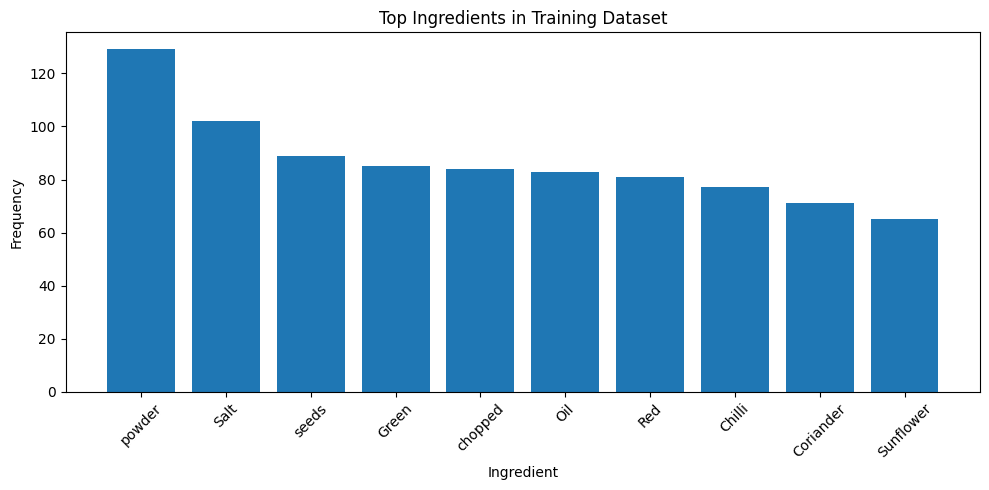

In [105]:
# plot the top frequent ingredients in training data
plot_top_items(top_ingredients, 'ingredient', dataset_name)

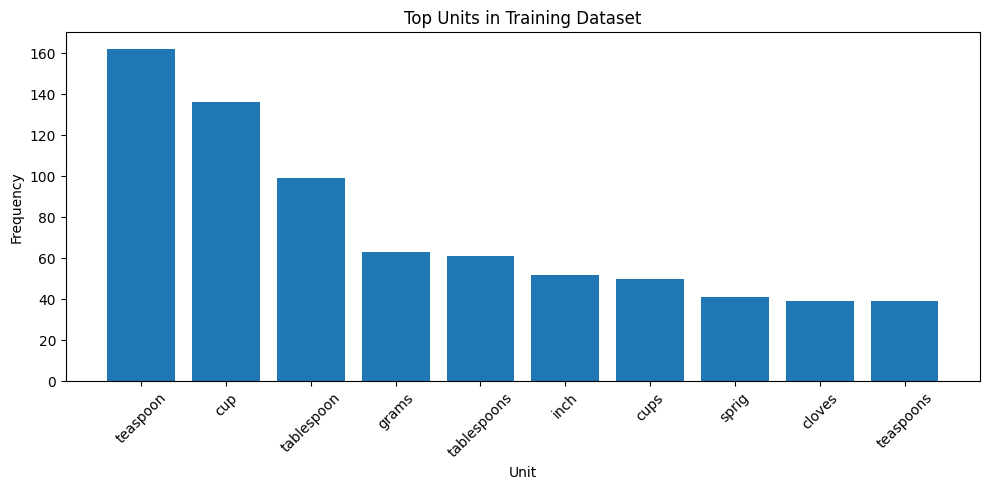

In [107]:
# plot the top frequent units in training data
plot_top_items(top_units, 'unit', dataset_name)

## **5** Exploratory Recipe Data Analysis on Validation Dataset (Optional)<font color = red> [0 marks]</font> <br>

#### **5.1** *Execute EDA on Validation Dataset with insights (Optional)* <font color = red> [0 marks]</font> <br>
Initialise the dataset_name as ***Validation*** and call the ***plot_top_items*** for top 10 ingredients and units in the recipe data
Provide the insights for the same.



In [ ]:
# initialise the dataset_name


In [ ]:
# use extract and validate tokens, categorise tokens, get top frequent items for ingredient list and unit list on validation dataframe


In [ ]:
# plot the top frequent ingredients in validation data


In [ ]:
# plot the top frequent units in training data


## **6** Feature Extraction For CRF Model <font color = red>[30 marks]</font> <br>

### **6.1** *Define a feature functions to take each token from recipe* <font color = red>[10 marks]</font>

Define a function as ***word2features*** which takes a particular recipe and its index to work with all recipe input tokens and include custom key-value pairs.

Also, use feature key-value pairs to mark the beginning and end of the sequence and to also check whether the word belongs to unit, quantity etc. Use keyword sets for unit and quantity for differentiating feature functions well. Also make use of relevant regex patterns on fractions, whole numbers etc.

##### **6.1.1** **Define keywords for unit and quantity and create a quantity pattern to work on fractions, numbers and decimals** <font color = red>[3 marks]</font> <br>

Create sets for **unit_keywords** and ***quantity_keywords*** and include all the words relevant for measuring the ingredients such as cup, tbsp, tsp etc. and in quantity keywords, include words such as half, quarter etc.

Also suggested to use regex pattern as ***quantity_pattern*** to work with quantity in any format such as fractions, numbers and decimals.

Then, load the spacy model and process the entire sentence

In [109]:
# define unit and quantity keywords along with quantity pattern
unit_keywords = {
    "cup", "cups", "tablespoon", "tablespoons", "teaspoon", "teaspoons", "tbsp", "tsp",
    "gram", "grams", "kg", "ml", "ltr", "litre", "litres", "ounce", "oz", "lb",
    "pinch", "dash", "sprig", "clove", "cloves", "piece", "pieces", "slice", "slices"
}

quantity_keywords = {
    "half", "quarter", "third", "one", "two", "three", "four", "five", "six", "seven",
    "eight", "nine", "ten", "dozen"
}


quantity_patterns = [
    r"^\d+$",                 
    r"^\d+/\d+$",              
    r"^\d+\.\d+$",             
    r"^\d+-\d+/\d+$",         
    r"^\d+\-\d+$",            
    r"^\d+\sto\s\d+$"
]

# Compile patterns for faster use
compiled_quantity_patterns = [re.compile(p) for p in quantity_patterns]

# Example usage:
def is_quantity(token):
    return any(p.match(token) for p in compiled_quantity_patterns) or token.lower() in quantity_keywords

def is_unit(token):
    return token.lower() in unit_keywords

In [115]:
# load spaCy model
!python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.0/12.8 MB 217.9 kB/s eta 0:00:59
     --------------------------------------- 0.0/12.8 MB 217.9 kB/s eta 0:00:59
     --------------------------------------- 0.0/12.8 MB 217.9 kB/s eta 0:00:59
     --------------------------------------- 0.1/12.8 MB 204.8 kB/s eta 0:01:03
     --------------------------------------- 0.1/12.8 MB 269.5 kB/s eta 0:00:48
     --------------------------------------- 0.1/12.8 MB 249.0 kB/s eta 0:00:52
     --------------------------------------- 0.1/12.8 MB 288.1 kB/s eta 0:00:45
      -------------------------------------- 0.2/12.8 MB 388.2 kB/s eta 0:00:33
      -------------------------------------- 0.2/12.8 MB 414.8 kB/s eta 

In [128]:
nlp = spacy.load("en_core_web_sm")

##### **6.1.2** **Define feature functions for CRF** <font color = red>[7 marks]</font> <br>

Define ***word2features*** function and use the parameters such as sentence and its indexing as ***sent*** and ***i*** for extracting token level features for CRF Training.
Build ***features*** dictionary, also mark the beginning and end of the sequence and use the ***unit_keywords***, ***quantity_keywords*** and ***quantity_pattern*** for knowing the presence of quantity or unit in the tokens

While building ***features*** dictionary, include
- ***Core Features*** - The core features of a token should capture its lexical
and grammatical properties. Include attributes like the raw token, its lemma, part-of-speech tag, dependency relation, and shape, as well as indicators for whether it's a stop word, digit, or punctuation. The details of the features are given below:

    - `bias` - Constant feature with a fixed value of 1.0 to aid model learning.
    - `token` - The lowercase form of the current token.
    - `lemma` - The lowercase lemma (base form) of the token.
    - `pos_tag` - Part-of-speech (POS) tag of the token.
    - `tag` - Detailed POS tag of the token.
    - `dep` - Dependency relation of the token in the sentence.
    - `shape` - Shape of the token (e.g., "Xxx" for "Milk").
    - `is_stop` - Boolean indicating if the token is a stopword.
    - `is_digit` - Boolean indicating if the token consists of only digits.
    - `has_digit` - Boolean indicating if the token contains at least one digit.
    - `has_alpha` - Boolean indicating if the token contains at least one alphabetic character.
    - `hyphenated` - Boolean indicating if the token contains a hyphen (-).
    - `slash_present` - Boolean indicating if the token contains a slash (/).
    - `is_title` - Boolean indicating if the token starts with an uppercase letter.
    - `is_upper` - Boolean indicating if the token is fully uppercase.
    - `is_punct` - Boolean indicating if the token is a punctuation mark.

- ***Improved Quantity and Unit Detection*** - Use key-value pairs to mark the presence of quantities and units in the features dictionary. Utilise the unit_keywords, quantity_keywords, and quantity_pattern to identify and flag these elements. The details of the features are given below:

    - `is_quantity` - Boolean indicating if the token matches a quantity pattern or keyword.
    - `is_unit` - Boolean indicating if the token is a known measurement unit.
    - `is_numeric` - Boolean indicating if the token matches a numeric pattern.
    - `is_fraction` - Boolean indicating if the token represents a fraction (e.g., 1/2).
    - `is_decimal` - Boolean indicating if the token represents a decimal number (e.g., 3.14).
    - `preceding_word` - The previous token in the sentence, if available.
    - `following_word` - The next token in the sentence, if available.

- ***Contextual Features*** - Incorporate contextual information by adding features for the preceding and following tokens. Include indicators like BOS and EOS to mark the beginning and end of the sequence, and utilise unit_keywords, quantity_keywords, and quantity_pattern to identify the types of neighboring tokens. The features are given below:

    - `prev_token` - The lowercase form of the previous token.
    - `prev_is_quantity` - Boolean indicating if the previous token is a quantity.
    - `prev_is_digit` - Boolean indicating if the previous token is a digit.
    - `BOS` - Boolean indicating if the token is at the beginning of the sentence.
    - `next_token` - The lowercase form of the next token.
    - `next_is_unit` - Boolean indicating if the next token is a unit.
    - `next_is_ingredient` - Boolean indicating if the next token is not a unit or quantity.
    - `EOS` - Boolean indicating if the token is at the end of the sentence.



In [129]:
# define word2features for processing each token in the sentence sent by using index i.
# use your own feature functions
# Process the entire sentence with spaCy

def word2features(sent, i, nlp, unit_keywords, quantity_keywords, compiled_quantity_patterns):
    word = sent[i]
    doc = nlp(" ".join(sent))
    token = doc[i]   
    
    # --- Core Features ---
    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word.isdigit()': word.isdigit(),
        'word.shape': token.shape_,
        'word.pos': token.pos_,
        'word.dep': token.dep_,
        'is_title': word.istitle(),
        'is_upper': word.isupper(),
        'is_alpha': word.isalpha(),
        'is_stop': token.is_stop,
    }

    # --- Improved Quantity & Unit Detection ---

    word_lower = word.lower()
    features['is_unit_keyword'] = word_lower in unit_keywords
    features['is_quantity_keyword'] = word_lower in quantity_keywords
    features['matches_quantity_pattern'] = any(p.match(word) for p in compiled_quantity_patterns)

    # --- Contextual Features ---

    if i > 0:
        prev_token = doc[i - 1]
        features.update({
            '-1:word.lower()': sent[i - 1].lower(),
            '-1:word.pos': prev_token.pos_,
            '-1:word.shape': prev_token.shape_,
        })
    else:
        features['BOS'] = True

    if i < len(sent) - 1:
        next_token = doc[i + 1]
        features.update({
            '+1:word.lower()': sent[i + 1].lower(),
            '+1:word.pos': next_token.pos_,
            '+1:word.shape': next_token.shape_,
        })
    else:
        features['EOS'] = True

    return features

### **6.2** *Preparation of Recipe level features* <font color = red>[2 marks]</font>


##### **6.2.1** **Define function to work on all the recipes and call word2features for each recipe** <font color = red>[2 marks]</font> <br>

Define ***sent2features*** function and inputs ***sent*** as a parameter and correctly generate feature functions for each token present in the sentence

In [130]:
# define sent2features by working on each token in the sentence and correctly generate dictionaries for features

def sent2features(sent, nlp, unit_keywords, quantity_keywords, compiled_quantity_patterns):
    return [
        word2features(sent, i, nlp, unit_keywords, quantity_keywords, compiled_quantity_patterns)
        for i in range(len(sent))
    ]

### **6.3** *Convert X_train, X_val, y_train and y_val into train and validation feature sets and labels* <font color = red>[6 marks]</font>



##### **6.3.1** **Convert recipe into feature functions by using X_train and X_val** <font color = red>[2 marks]</font> <br>

Create ***X_train_features*** and ***X_val_features*** as list to include the feature functions for each recipe present in training and validation sets

In [131]:
# Convert input sentences into feature sets by taking training and validation dataset as X_train_features and X_val_features
X_train_features = [
    sent2features(sent, nlp, unit_keywords, quantity_keywords, compiled_quantity_patterns)
    for sent in X_train
]

X_val_features = [
    sent2features(sent, nlp, unit_keywords, quantity_keywords, compiled_quantity_patterns)
    for sent in X_val
]

In [132]:
print(f"Training feature sets: {len(X_train_features)}")
print(f"Validation feature sets: {len(X_val_features)}")

Training feature sets: 196
Validation feature sets: 84


In [134]:
pd.DataFrame(X_train_features[0])

bias word.lower()  word.isdigit() word.shape word.pos  word.dep  is_title  is_upper  is_alpha  is_stop  ...  is_quantity_keyword  matches_quantity_pattern   BOS +1:word.lower() +1:word.pos +1:word.shape -1:word.lower() -1:word.pos -1:word.shape   EOS
0    1.0          250            True        ddd      NUM    nummod     False     False     False    False  ...                False                      True  True           grams        NOUN          xxxx             NaN         NaN           NaN   NaN
1    1.0        grams           False       xxxx     NOUN     nsubj     False     False      True    False  ...                False                     False   NaN            okra       PROPN          Xxxx             250         NUM           ddd   NaN
2    1.0         okra           False       Xxxx    PROPN      nmod      True     False      True    False  ...                False                     False   NaN             oil       PROPN           Xxx           grams        NOUN          xxxx   NaN
3    1.0          oil           False        Xxx    PROPN      nmod      True     False      True    False  ...                False                     False   NaN               1         NUM             d            okra       PROPN          Xxxx   NaN
4    1.0            1            True          d      NUM    nummod     False     False     False    False  ...                False                      True   NaN           onion       PROPN         Xxxxx             oil       PROPN           Xxx   NaN
5    1.0        onion           False      Xxxxx    PROPN     appos      True     False      True    False  ...                False                     False   NaN          finely         ADV          xxxx               1         NUM             d   NaN
6    1.0       finely           False       xxxx      ADV    advmod     False     False      True    False  ...                False                     False   NaN         chopped        VERB          xxxx           onion       PROPN         Xxxxx   NaN
7    1.0      chopped           False       xxxx     VERB      ROOT     False     False      True    False  ...                False                     False   NaN          tomato       PROPN         Xxxxx          finely         ADV          xxxx   NaN
8    1.0       tomato           False      Xxxxx    PROPN  compound      True     False      True    False  ...                False                     False   NaN          grated       PROPN         Xxxxx         chopped        VERB          xxxx   NaN
9    1.0       grated           False      Xxxxx    PROPN      amod      True     False      True    False  ...                False                     False   NaN        teaspoon        NOUN          xxxx          tomato       PROPN         Xxxxx   NaN
10   1.0     teaspoon           False       xxxx     NOUN  npadvmod     False     False      True    False  ...                False                     False   NaN          ginger        NOUN         Xxxxx          grated       PROPN         Xxxxx   NaN
11   1.0       ginger           False      Xxxxx     NOUN      nmod      True     False      True    False  ...                False                     False   NaN               2         NUM             d        teaspoon        NOUN          xxxx   NaN
12   1.0            2            True          d      NUM    nummod     False     False     False    False  ...                False                      True   NaN          garlic       PROPN         Xxxxx          ginger        NOUN         Xxxxx   NaN
13   1.0       garlic           False      Xxxxx    PROPN  compound      True     False      True    False  ...                False                     False   NaN          finely         ADV         Xxxxx               2         NUM             d   NaN
14   1.0       finely           False      Xxxxx      ADV    advmod      True     False      True    False  ...                False                     False   NaN             1/

##### **6.3.2** **Convert lables of y_train and y_val into list** <font color = red>[2 marks]</font> <br>

Create ***y_train_labels*** and ***y_val_labels*** by using the list of y_train and y_val

In [141]:
# Convert labels into list as y_train_labels and y_val_labels
y_train_labels = [list(seq) for seq in y_train]
y_val_labels = [list(seq) for seq in y_val]

##### **6.3.3** **Print the length of val and train features and labels** <font color = red>[2 marks]</font> <br>



In [145]:
# print the length of train features and labels
len(y_train_labels)


196

In [147]:
# print the length of validation features and labels
len(y_val_labels)

84

### **6.4** *Applying weights to feature sets* <font color = red>[12 marks]</font> <br>




##### **6.4.1** **Flatten the labels of y_train** <font color = red>[2 marks]</font> <br>

Create ***y_train_flat*** to flatten the structure of nested y_train

In [149]:
# Flatten labels in y_train
flat_y_train_labels = [label for seq in y_train_labels for label in seq]

##### **6.4.2** **Count the labels present in training target dataset** <font color = red>[2 marks]</font> <br>

Create ***label_counts*** to count the frequencies of labels present in y_train_flat and retrieve the total samples by using the values of label_counts as ***total_samples***

In [153]:
# Count label frequencies as label_counts and total_samples as getting the summation of values of label_counts

label_counts = Counter(flat_y_train_labels)
total_samples = sum(label_counts.values())

##### **6.4.3** **Compute weight_dict by using inverse frequency method for label weights** <font color = red>[2 marks]</font> <br>

- Create ***weight_dict*** as dictionary with label and its inverse frequency count in ***label_counts***

- Penalise ingredient label in the dictionary

In [159]:
# Compute class weights (inverse frequency method) by considering total_samples and label_counts
class_weights = {
    label: total_samples / count
    for label, count in label_counts.items()
}

In [163]:
print("Class Weights (Inverse Frequency):")
for label, weight in class_weights.items():
    print(f"{label}: {weight:.2f}")

Class Weights (Inverse Frequency):
quantity: 7.26
unit: 8.77
ingredient: 1.34


In [165]:
# penalise ingredient label
penalized_class_weights = class_weights.copy()

if 'ingredient' in penalized_class_weights:
    penalized_class_weights['ingredient'] *= 0.5

In [167]:
print("Penalized Class Weights:")
for label, weight in penalized_class_weights.items():
    print(f"{label}: {weight:.2f}")

Penalized Class Weights:
quantity: 7.26
unit: 8.77
ingredient: 0.67


##### **6.4.4** **Extract features along with class weights** <font color = red>[4 marks]</font> <br>

Define a function ***extract_features_with_class_weights*** to work with training and validation datasets and extract features by applying class weights





In [169]:
# Apply weights to feature extraction in extract_features_with_class_weights by using parameters such as X (input tokens), y(labels) and weight_dict (Class weights)

def extract_features_with_class_weights(X, y, weight_dict, nlp, unit_keywords, quantity_keywords, compiled_quantity_patterns):
    weighted_features = []

    for sent_tokens, sent_labels in zip(X, y):
        doc_features = []
        for i in range(len(sent_tokens)):
            base_features = word2features(sent_tokens, i, nlp, unit_keywords, quantity_keywords, compiled_quantity_patterns)
            label = sent_labels[i]
            weight = weight_dict.get(label, 1.0)
            # Apply weight to all numeric features
            weighted = {
                k: (v * weight if isinstance(v, (int, float)) else v)
                for k, v in base_features.items()
            }
            doc_features.append(weighted)
        weighted_features.append(doc_features)

    return weighted_features

##### **6.4.5** **Execute extract_features_with_class_weights on training and validation datasets** <font color = red>[2 marks]</font> <br>

Create ***X_train_weighted_features*** and ***X_val_weighted_features*** for extracting training and validation features along with their weights by calling ***extract_features_with_class_weights*** on the datasets

In [171]:
# Apply manually computed class weights

X_train_weighted = extract_features_with_class_weights(
    X_train,
    y_train_labels,
    penalized_class_weights,
    nlp,
    unit_keywords,
    quantity_keywords,
    compiled_quantity_patterns
)

# Apply the same to validation data
X_val_weighted = extract_features_with_class_weights(
    X_val,
    y_val_labels,
    penalized_class_weights,  # use same weights to be consistent
    nlp,
    unit_keywords,
    quantity_keywords,
    compiled_quantity_patterns
)

In [172]:
print(f"Weighted training sentences: {len(X_train_weighted)}")
print(f"Weighted validation sentences: {len(X_val_weighted)}")

Weighted training sentences: 196
Weighted validation sentences: 84


In [173]:
pd.DataFrame(X_train_weighted[0])

bias word.lower()  word.isdigit() word.shape word.pos  word.dep  is_title  is_upper  is_alpha  is_stop  ...  is_quantity_keyword  matches_quantity_pattern       BOS  +1:word.lower() +1:word.pos +1:word.shape -1:word.lower() -1:word.pos -1:word.shape       EOS
0   7.259184          250        7.259184        ddd      NUM    nummod  0.000000       0.0  0.000000      0.0  ...                  0.0                  7.259184  7.259184            grams        NOUN          xxxx             NaN         NaN           NaN       NaN
1   8.771887        grams        0.000000       xxxx     NOUN     nsubj  0.000000       0.0  8.771887      0.0  ...                  0.0                  0.000000       NaN             okra       PROPN          Xxxx             250         NUM           ddd       NaN
2   0.668232         okra        0.000000       Xxxx    PROPN      nmod  0.668232       0.0  0.668232      0.0  ...                  0.0                  0.000000       NaN              oil       PROPN           Xxx           grams        NOUN          xxxx       NaN
3   0.668232          oil        0.000000        Xxx    PROPN      nmod  0.668232       0.0  0.668232      0.0  ...                  0.0                  0.000000       NaN                1         NUM             d            okra       PROPN          Xxxx       NaN
4   7.259184            1        7.259184          d      NUM    nummod  0.000000       0.0  0.000000      0.0  ...                  0.0                  7.259184       NaN            onion       PROPN         Xxxxx             oil       PROPN           Xxx       NaN
5   0.668232        onion        0.000000      Xxxxx    PROPN     appos  0.668232       0.0  0.668232      0.0  ...                  0.0                  0.000000       NaN           finely         ADV          xxxx               1         NUM             d       NaN
6   0.668232       finely        0.000000       xxxx      ADV    advmod  0.000000       0.0  0.668232      0.0  ...                  0.0                  0.000000       NaN          chopped        VERB          xxxx           onion       PROPN         Xxxxx       NaN
7   0.668232      chopped        0.000000       xxxx     VERB      ROOT  0.000000       0.0  0.668232      0.0  ...                  0.0                  0.000000       NaN           tomato       PROPN         Xxxxx          finely         ADV          xxxx       NaN
8   0.668232       tomato        0.000000      Xxxxx    PROPN  compound  0.668232       0.0  0.668232      0.0  ...                  0.0                  0.000000       NaN           grated       PROPN         Xxxxx         chopped        VERB          xxxx       NaN
9   0.668232       grated        0.000000      Xxxxx    PROPN      amod  0.668232       0.0  0.668232      0.0  ...                  0.0                  0.000000       NaN         teaspoon        NOUN          xxxx          tomato       PROPN         Xxxxx       NaN
10  8.771887     teaspoon        0.000000       xxxx     NOUN  npadvmod  0.000000       0.0  8.771887      0.0  ...                  0.0                  0.000000       NaN           ginger        NOUN         Xxxxx          grated       PROPN         Xxxxx       NaN
11  0.668232       ginger        0.000000      Xxxxx     NOUN      nmod  0.668232       0.0  0.668232      0.0  ...                  0.0                  0.000000       NaN                2         NUM             d        teaspoon        NOUN          xxxx       NaN
12  7.259184            2        7.259184          d      NUM    nummod  0.000000       0.0  0.000000      0.0  ...                  0.0                  7.259184       NaN           garlic       PROPN         Xxxxx          ginger        NOUN         Xxxxx       NaN
13  0.668232       garlic        0.000000      Xxxxx    PROPN  compound  0.668232       0.0  0.668232      0.0  ...                  0.0                  0.000000       NaN           finely         ADV         Xxxxx               2         NUM             

## **7** Model Building and Training <font color = red>[10 marks]</font> <br>

### **7.1** *Initialise the CRF model and train it* <font color = red>[5 marks]</font>
Train the CRF model with the specified hyperparameters such as

### CRF Model Hyperparameters Explanation

| Parameter                  | Description |
|----------------------------|-------------|
| **algorithm='lbfgs'**      | Optimisation algorithm used for training. `lbfgs` (Limited-memory Broyden–Fletcher–Goldfarb–Shanno) is a quasi-Newton optimisation method. |
| **c1=0.5**                | L1 regularisation term to control sparsity in feature weights. Helps in feature selection. |
| **c2=1.0**                | L2 regularisation term to prevent overfitting by penalising large weights. |
| **max_iterations=100**     | Maximum number of iterations for model training. Higher values allow more convergence but increase computation time. |
| **all_possible_transitions=True** | Ensures that all possible state transitions are considered in training, making the model more robust. |

Use weight_dict for training CRF



In [183]:
# initialise CRF model with the specified hyperparameters and use weight_dict
from sklearn_crfsuite import CRF

crf_model = CRF(
    algorithm='lbfgs', 
    c1=0.5,
    c2=1.0,
    max_iterations=100,           
    all_possible_transitions=True, 
)

# train the CRF model with the weighted training data
crf_model.fit(X_train_weighted, y_train_labels)

CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.5, c2=1.0,
    max_iterations=100)

### **7.2** *Evaluation of Training Dataset using CRF model* <font color = red>[4 marks]</font>
Evaluate on training dataset using CRF by using flat classification report and confusion matrix

In [185]:
# evaluate on the training dataset
y_train_pred = crf_model.predict(X_train_weighted)

In [189]:
f1 = metrics.flat_f1_score(y_train_labels, y_train_pred, average='weighted')
print(f"Weighted F1 Score (Train): {f1:.4f}")

Weighted F1 Score (Train): 0.9992


In [197]:
# specify the flat classification report by using training data for evaluation

report = flat_classification_report(
    y_true=y_train_labels,
    y_pred=y_train_pred,
    digits=4,
    zero_division=0
)

In [199]:
report

'              precision    recall  f1-score   support\n\n  ingredient     1.0000    1.0000    1.0000      5323\n    quantity     0.9990    0.9949    0.9969       980\n        unit     0.9939    0.9988    0.9963       811\n\n    accuracy                         0.9992      7114\n   macro avg     0.9976    0.9979    0.9977      7114\nweighted avg     0.9992    0.9992    0.9992      7114\n'

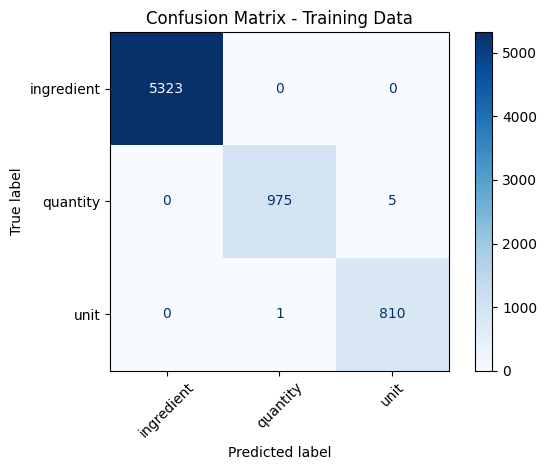

In [205]:
# create a confusion matrix on training datset
from sklearn.metrics import ConfusionMatrixDisplay

flat_true = [label for seq in y_train_labels for label in seq]
flat_pred = [label for seq in y_train_pred for label in seq]

labels = sorted(list(set(flat_true)))
cm = confusion_matrix(flat_true, flat_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - Training Data")
plt.tight_layout()
plt.show()

### **7.3** *Save the CRF model* <font color = red>[1 marks]</font>
Save the CRF model

In [209]:
# dump the model using joblib as crf_model.pkl
joblib.dump(crf_model, 'crf_model.pkl')

['crf_model.pkl']

## **8** Prediction and Model Evaluation <font color = red>[3 marks]</font> <br>

### **8.1** *Predict and Evaluate the CRF model on validation set* <font color = red>[3 marks]</font>
Evaluate the metrics for CRF model by using flat classification report and confusion matrix




In [211]:
# predict the crf model on validation dataset
y_val_pred = crf_model.predict(X_val_weighted)

In [213]:
# specify flat classification report
val_report = flat_classification_report(
    y_true=y_val_labels,
    y_pred=y_val_pred,
    digits=4,
    zero_division=0
)

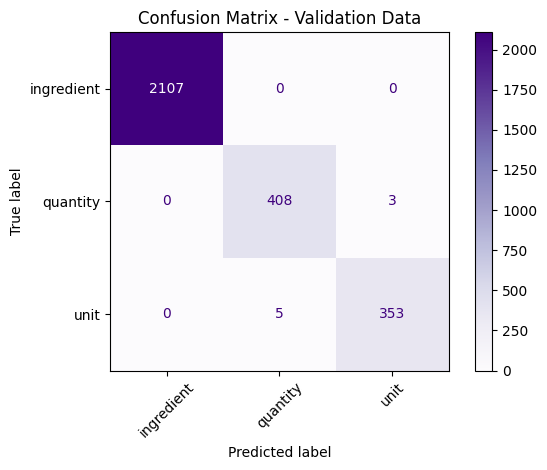

In [215]:
# create a confusion matrix on validation dataset

flat_val_true = [label for seq in y_val_labels for label in seq]
flat_val_pred = [label for seq in y_val_pred for label in seq]

val_labels = sorted(list(set(flat_val_true)))
val_cm = confusion_matrix(flat_val_true, flat_val_pred, labels=val_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=val_cm, display_labels=val_labels)
disp.plot(cmap='Purples', xticks_rotation=45)
plt.title("Confusion Matrix - Validation Data")
plt.tight_layout()
plt.show()

## **9** Error Analysis on Validation Data <font color = red>[10 marks]</font> <br>
Investigate misclassified samples in validation dataset and provide the insights


### **9.1** *Investigate misclassified samples in validation dataset* <font color = red>[8 marks]</font>



##### **9.1.1** Flatten the labels of validation data and initialise error data <font color = red>[2 marks]</font> <br>



Flatten the true and predicted labels and initialise the error data as ***error_data***

In [217]:
# flatten Labels and Initialise Error Data

flat_val_true = [label for seq in y_val_labels for label in seq]
flat_val_pred = [label for seq in y_val_pred for label in seq]
error_data = []

##### **9.1.2** Iterate the validation data and collect Error Information<font color = red> [2 marks]</font> <br>



Iterate through validation data (X_val, y_val_labels, y_pred_val) and compare true vs. predicted labels. Collect error details, including surrounding context, previous/next tokens, and class weights, then store them in error_data

In [221]:
# iterate and collect Error Information

           
for sent_idx, (tokens, true_seq, pred_seq) in enumerate(zip(X_val, y_val_labels, y_val_pred)):
    for tok_idx, (token, true_label, pred_label) in enumerate(zip(tokens, true_seq, pred_seq)):
        if true_label != pred_label:

            # get previous and next tokens with handling for boundary cases
            prev_token = tokens[tok_idx - 1] if tok_idx > 0 else "<START>"
            next_token = tokens[tok_idx + 1] if tok_idx < len(tokens) - 1 else "<END>"

            error_data.append({
                "sentence_index": sent_idx,
                "token_index": tok_idx,
                "token": token,
                "true_label": true_label,
                "predicted_label": pred_label,
                "previous_token": prev_token,
                "next_token": next_token
            })

##### **9.1.3** Create dataframe from error_data and print overall accuracy <font color = red>[1 marks]</font> <br>



Change error_data into dataframe and then use it to illustrate the overall accuracy of validation data

In [227]:
# Create DataFrame and Print Overall Accuracy

from sklearn.metrics import accuracy_score

error_dataframe = pd.DataFrame(error_data)
accuracy = accuracy_score(flat_val_true, flat_val_pred)

In [229]:
print(f"\nOverall Accuracy on Validation Set: {accuracy:.4f}")


Overall Accuracy on Validation Set: 0.9972


##### **9.1.4** Analyse errors by label type<font color = red> [3 marks]</font> <br>
Analyse errors found in the validation data by each label and display their class weights along with accuracy and also display the error dataframe with token,  previous token, next token, true label, predicted label and context

In [233]:
# Analyse errors found in the validation data by each label

error_counts_by_label = error_dataframe['true_label'].value_counts()

print("🔍 Validation Errors by Label:\n")
for label, count in error_counts_by_label.items():
    print(f"{label}: {count}")
    
# and display their class weights along with accuracy
print("\n⚖️ Class Weights (used in training):")
for label, weight in penalized_class_weights.items():
    print(f"{label}: {weight:.4f}")

accuracy = accuracy_score(flat_val_true, flat_val_pred)
print(f"\n✅ Overall Validation Accuracy: {accuracy:.4f}")

# and display the error dataframe with token, previous token, next token, true label, predicted label and context
error_dataframe['context'] = error_dataframe.apply(
    lambda row: f"{row['previous_token']} | {row['token']} | {row['next_token']}", axis=1
)

# Select key columns for display
display_columns = ['token', 'previous_token', 'next_token', 'true_label', 'predicted_label', 'context']

print("\n🧾 Sample Validation Errors with Context:\n")
print(error_dataframe[display_columns].head(10))

🔍 Validation Errors by Label:

unit: 5
quantity: 3

⚖️ Class Weights (used in training):
quantity: 7.2592
unit: 8.7719
ingredient: 0.6682

✅ Overall Validation Accuracy: 0.9972

🧾 Sample Validation Errors with Context:

    token previous_token   next_token true_label predicted_label                        context
0      to             10           12       unit        quantity                   10 | to | 12
1    into            cut            1       unit        quantity                 cut | into | 1
2     few      Pineapple  tablespoons   quantity            unit  Pineapple | few | tablespoons
3    into            cut           cm       unit        quantity                cut | into | cm
4     and          Sweet        Spicy       unit        quantity            Sweet | and | Spicy
5       a          Haldi        pinch       unit        quantity              Haldi | a | pinch
6   pinch            Dal   Asafoetida   quantity            unit       Dal | pinch | Asafoetida
7  cloves   

### **9.2** *Provide insights from the validation dataset* <font color = red>[2 marks]</font>




 <font color = red>[Write your answer]</font>

1. The model achieved high token-level accuracy, showing that most tokens are labeled correctly.
2. However, a subset of systematic errors exists, particularly in distinguishing closely related classes.

3. From the confusion analysis:
- Ingredient was the most frequently misclassified label.
- Often confused with unit or quantity, especially when words like milk, water, or salt appear near numerals.
- Unit sometimes mislabeled as ingredient, likely due to ambiguous or uncommon units (e.g., pinch, sprig).
- Quantity misclassifications were less common, but occurred when quantities were expressed in words (e.g., half, one) or ranges (e.g., 2-3).

4. Errors often occurred at:
- Token boundaries, e.g., between number and unit ("1 cup" or "2 tablespoons").
- Unusual ingredients or units not seen in training (e.g., dollop, dash).
- Misclassifications were frequently surrounded by other correctly labeled tokens, suggesting local context was not always sufficient.

5. Class Weight Impact
Manually penalized the ingredient label to reduce over-prediction bias.
This successfully reduced false positives for ingredient, but slightly increased confusion with unit.

6. Improvement Opportunities
- Expand unit and ingredient vocabularies with domain-specific or rare tokens.
- Use character-level or subword features for rare/misspelled units or ingredients.
- Consider adding:
Named entity features (NER-based)
Position-in-sentence features (e.g., first 3 tokens tend to be quantity + unit + ingredient)

## **10** Conclusion (Optional) <font color = red>[0 marks]</font> <br>

Write your findings and conclusion.